<a href="https://colab.research.google.com/github/Kuzay3t/Wells_classification/blob/main/Model_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing necessary libaries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

In [ ]:
# uploading necessary files

from google.colab import files
file = files.upload()

Saving classification_parameters.csv to classification_parameters.csv
Saving Innovisors_DSEATS_Africa_2025_Classification.csv to Innovisors_DSEATS_Africa_2025_Classification.csv
Saving reservoir_info.csv to reservoir_info.csv
Saving spe_africa_dseats_datathon_2025_wells_dataset.csv to spe_africa_dseats_datathon_2025_wells_dataset (1).csv


In [ ]:
# reading the csv files

wells_df = pd.read_csv("spe_africa_dseats_datathon_2025_wells_dataset.csv")
reservoir_df = pd.read_csv("reservoir_info.csv")
classification_df = pd.read_csv("classification_parameters.csv")

## Data Preperation


1.   Handle Missing Values
2.   Converting numbers that are in string format
3.   Date formatting
4.   Handling odd and missing values
5.   Calculating daily production metrics





In [ ]:
# Handling missing values

wells_df.loc[(wells_df['ON_STREAM_HRS'] == 0) &
       (wells_df['CUMULATIVE_OIL_PROD (STB)'] == 0) &
       (wells_df['CUMULATIVE_FORMATION_GAS_PROD (MSCF)'] == 0) &
       (wells_df['CUMULATIVE_TOTAL_GAS_PROD (MSCF)'] == 0) &
       (wells_df['CUMULATIVE_WATER_PROD (BBL)'] == 0),
       ['CUMULATIVE_OIL_PROD (STB)', 'CUMULATIVE_FORMATION_GAS_PROD (MSCF)',
        'CUMULATIVE_TOTAL_GAS_PROD (MSCF)', 'CUMULATIVE_WATER_PROD (BBL)']] = np.nan

In [ ]:
#  Converting the String-formatted Numbers
numeric_cols = ['BOTTOMHOLE_FLOWING_PRESSURE (PSI)', 'ANNULUS_PRESS (PSI)',
                'WELL_HEAD_PRESSURE (PSI)', 'CUMULATIVE_OIL_PROD (STB)',
                'CUMULATIVE_FORMATION_GAS_PROD (MSCF)',
                'CUMULATIVE_TOTAL_GAS_PROD (MSCF)',
                'CUMULATIVE_WATER_PROD (BBL)']

for col in numeric_cols:
    if wells_df[col].dtype == object:
        wells_df[col] = wells_df[col].str.replace(',', '').astype(float)

In [ ]:
# formating the date
wells_df['PROD_DATE'] = pd.to_datetime(wells_df['PROD_DATE'], format='%d-%b-%y')

# Extracting date features that would be useful
wells_df['YEAR'] = wells_df['PROD_DATE'].dt.year
wells_df['MONTH'] = wells_df['PROD_DATE'].dt.month
wells_df['DAY'] = wells_df['PROD_DATE'].dt.day
wells_df['DAY_OF_WEEK'] = wells_df['PROD_DATE'].dt.dayofweek
wells_df['DAY_OF_YEAR'] = wells_df['PROD_DATE'].dt.dayofyear

In [ ]:
# handling outliers and negative values
# Replacing negative values with NaN
numeric_cols = wells_df.select_dtypes(include=[np.number]).columns
wells_df[numeric_cols] = wells_df[numeric_cols].apply(lambda x: x.where(x >= 0, np.nan))


In [ ]:
# Sorting the dataset by well and date to ensure proper differencing
wells_df = wells_df.sort_values(['WELL_NAME', 'PROD_DATE'])

# Calculating daily production i.e (difference between cumulative values)
for well in wells_df['WELL_NAME'].unique():
    well_mask = wells_df['WELL_NAME'] == well
    for prod_col in ['OIL', 'FORMATION_GAS', 'TOTAL_GAS', 'WATER']:
        # Construct the correct cumulative column name with units
        if prod_col == 'OIL':
            cum_col = 'CUMULATIVE_OIL_PROD (STB)'
        elif prod_col == 'FORMATION_GAS':
            cum_col = 'CUMULATIVE_FORMATION_GAS_PROD (MSCF)'
        elif prod_col == 'TOTAL_GAS':
            cum_col = 'CUMULATIVE_TOTAL_GAS_PROD (MSCF)'
        elif prod_col == 'WATER':
            cum_col = 'CUMULATIVE_WATER_PROD (BBL)'

        daily_col = f'DAILY_{prod_col}_PROD'

        # Calculating daily production
        wells_df.loc[well_mask, daily_col] = wells_df.loc[well_mask, cum_col].diff()

        # daily production equals cumulative
        first_idx = wells_df[well_mask].index[0]
        if not pd.isna(wells_df.loc[first_idx, cum_col]):
            wells_df.loc[first_idx, daily_col] = wells_df.loc[first_idx, cum_col]

        # Set to 0 when well wasn't operating
        wells_df.loc[well_mask & (wells_df['ON_STREAM_HRS'] == 0), daily_col] = 0

In [ ]:
# Forward filling for some operational parameters when well is temporarily shut
fill_cols = ['CHOKE_SIZE (%)', 'BOTTOMHOLE_FLOWING_PRESSURE (PSI)',
             'DOWNHOLE_TEMPERATURE (deg F)', 'ANNULUS_PRESS (PSI)',
             'WELL_HEAD_PRESSURE (PSI)', 'WELL_HEAD_TEMPERATURE (deg F)']

wells_df[fill_cols] = wells_df.groupby('WELL_NAME')[fill_cols].ffill()

In [ ]:
# Calculating production efficiency metrics
wells_df['GAS_OIL_RATIO'] = wells_df['DAILY_TOTAL_GAS_PROD'] / wells_df['DAILY_OIL_PROD']
wells_df['WATER_CUT'] = wells_df['DAILY_WATER_PROD'] / (wells_df['DAILY_OIL_PROD'] + wells_df['DAILY_WATER_PROD'])

# Calculating pressure differentials
wells_df['PRESSURE_DIFF'] = wells_df['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'] - wells_df['WELL_HEAD_PRESSURE (PSI)']

In [ ]:
# Checking for remaining missing values
missing_values = wells_df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Checking for inconsistent data (e.g., cumulative values decreasing)
for well in wells_df['WELL_NAME'].unique():
    well_df = wells_df[wells_df['WELL_NAME'] == well]
    for cum_col in ['CUMULATIVE_OIL_PROD (STB)', 'CUMULATIVE_FORMATION_GAS_PROD (MSCF)',
                   'CUMULATIVE_TOTAL_GAS_PROD (MSCF)', 'CUMULATIVE_WATER_PROD (BBL)']:
        if (well_df[cum_col].diff().dropna() < 0).any():
            print(f"Warning: Decreasing cumulative values in {cum_col} for {well}")

Missing values per column:
GAS_OIL_RATIO    885
WATER_CUT        884
dtype: int64


## Exploratory Data Analysis

**Basic Dataset Overview**

In [ ]:
# Displaying basic info
print(f"Time period: {wells_df['PROD_DATE'].min()} to {wells_df['PROD_DATE'].max()}")
print(f"Wells: {wells_df['WELL_NAME'].unique()}")
print(f"Total records: {len(wells_df)}")

# Summary statistics
print(wells_df.describe().transpose())

Time period: 2011-02-17 00:00:00 to 2016-08-12 00:00:00
Wells: ['Well_#1' 'Well_#10' 'Well_#11' 'Well_#12' 'Well_#13' 'Well_#14'
 'Well_#15' 'Well_#16' 'Well_#17' 'Well_#18' 'Well_#19' 'Well_#2'
 'Well_#20' 'Well_#3' 'Well_#4' 'Well_#5' 'Well_#6' 'Well_#7' 'Well_#8'
 'Well_#9']
Total records: 7955
                                       count                           mean  \
PROD_DATE                               7955  2013-08-26 16:25:49.516027648   
ON_STREAM_HRS                         7955.0                      21.623497   
BOTTOMHOLE_FLOWING_PRESSURE (PSI)     7955.0                    2613.811816   
DOWNHOLE_TEMPERATURE (deg F)          7955.0                     168.757429   
ANNULUS_PRESS (PSI)                   7955.0                     471.339542   
CHOKE_SIZE (%)                        7955.0                      56.155295   
WELL_HEAD_PRESSURE (PSI)              7955.0                     212.574151   
WELL_HEAD_TEMPERATURE (deg F)         7955.0                      86.

**Production Trend Per Time**

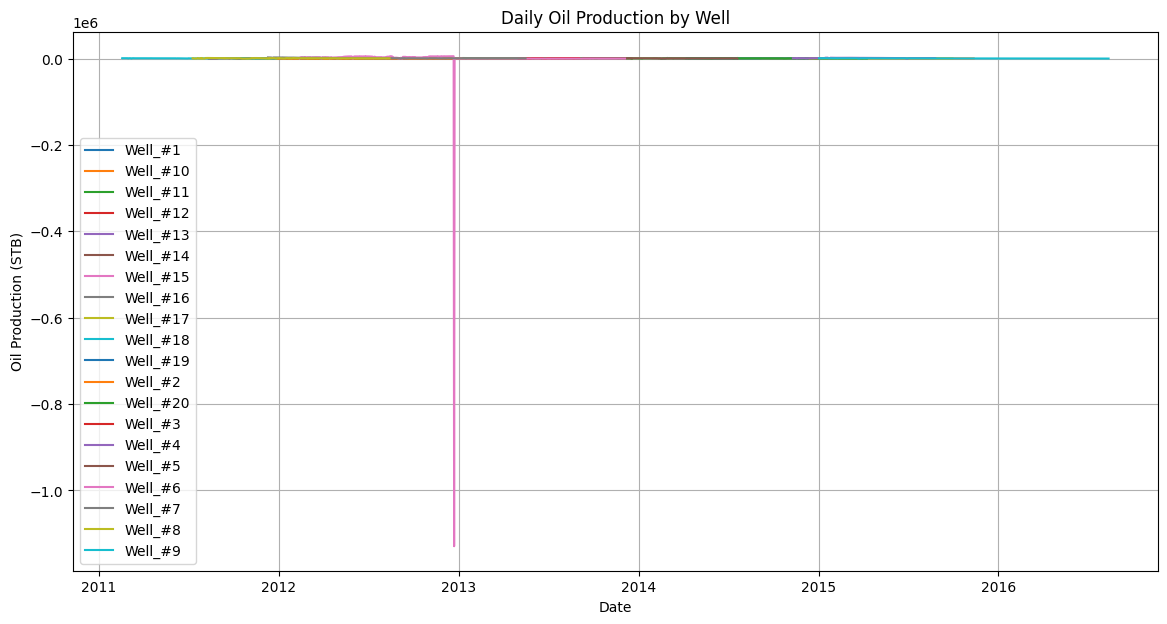

In [ ]:
# plotting oil production per well
plt.figure(figsize=(14, 7))
for well in wells_df['WELL_NAME'].unique():
    well_data = wells_df[wells_df['WELL_NAME'] == well]
    plt.plot(well_data['PROD_DATE'], well_data['DAILY_OIL_PROD'], label=well)
plt.title('Daily Oil Production by Well')
plt.xlabel('Date')
plt.ylabel('Oil Production (STB)')
plt.legend()
plt.grid(True)
plt.show()

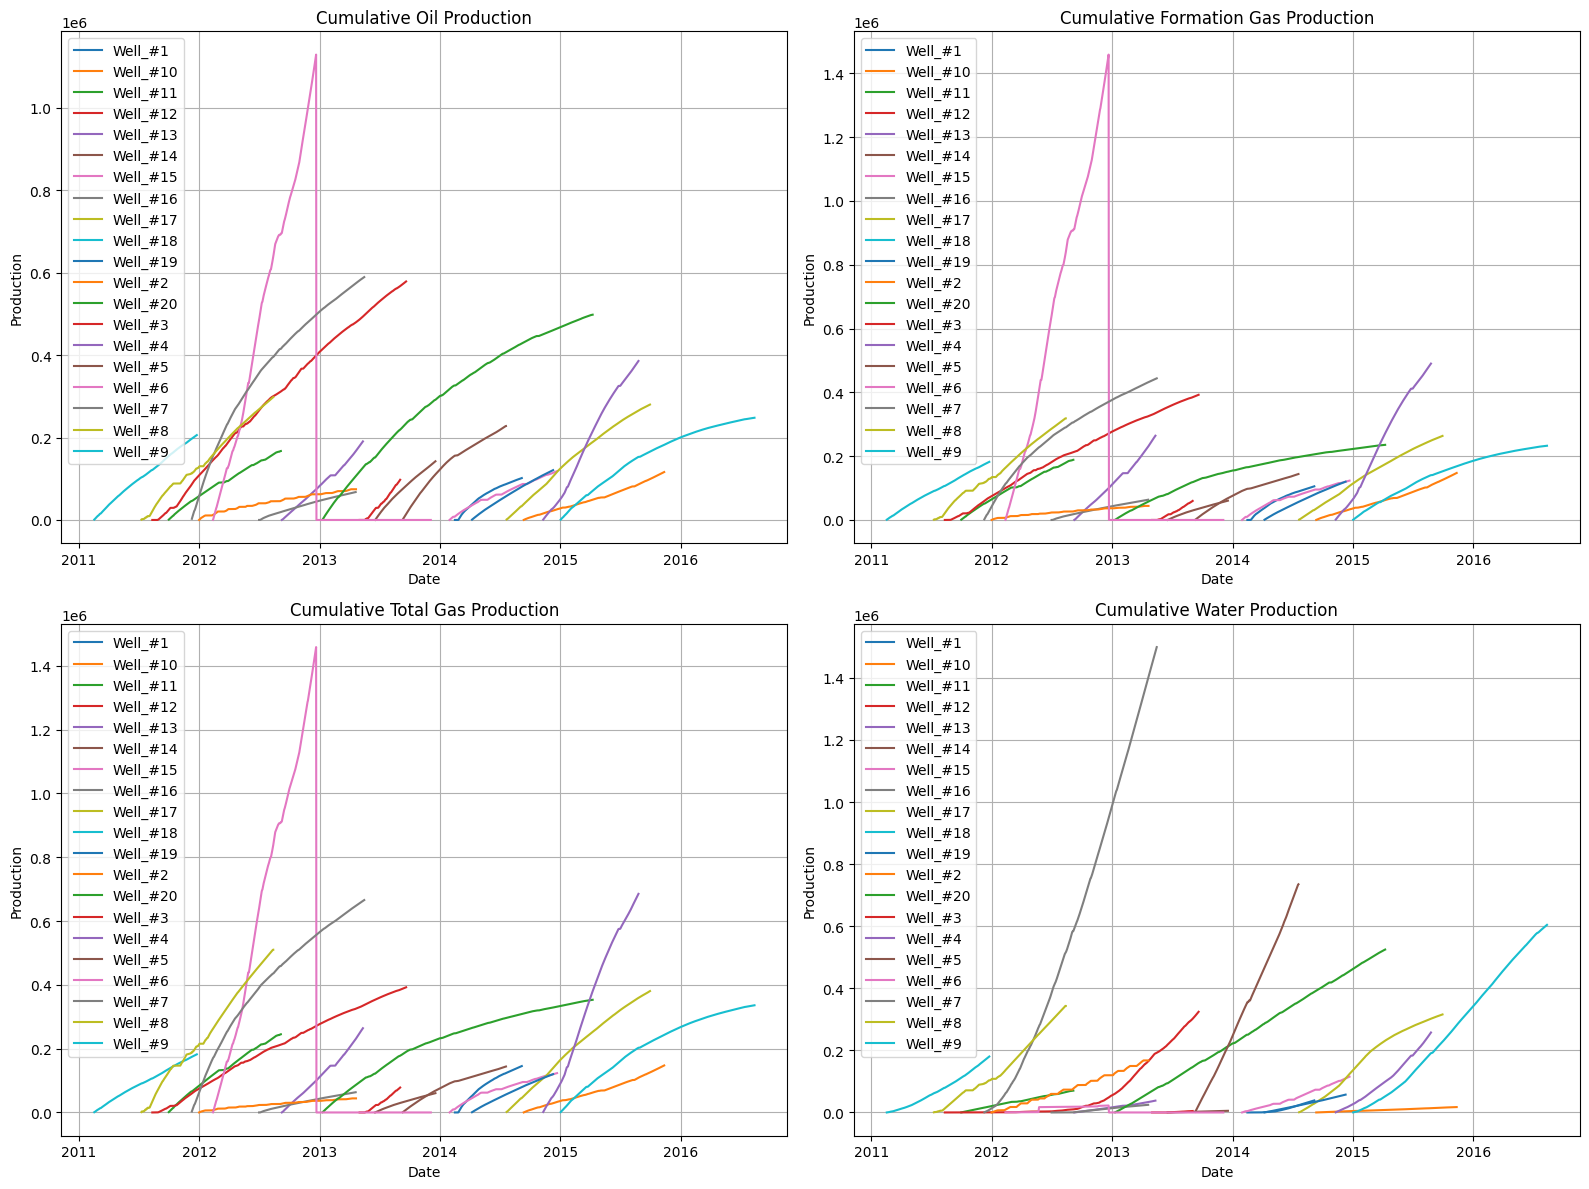

In [ ]:
# comparing the cumulative production of oil per well

fig, ax = plt.subplots(2, 2, figsize=(16, 12))
for i, prod_type in enumerate(['OIL', 'FORMATION_GAS', 'TOTAL_GAS', 'WATER']):
    row, col = i//2, i%2
    # Construct the correct cumulative column name with units
    if prod_type == 'OIL':
        cum_col = 'CUMULATIVE_OIL_PROD (STB)'
    elif prod_type == 'FORMATION_GAS':
        cum_col = 'CUMULATIVE_FORMATION_GAS_PROD (MSCF)'
    elif prod_type == 'TOTAL_GAS':
        cum_col = 'CUMULATIVE_TOTAL_GAS_PROD (MSCF)'
    elif prod_type == 'WATER':
        cum_col = 'CUMULATIVE_WATER_PROD (BBL)'

    for well in wells_df['WELL_NAME'].unique():
        well_data = wells_df[wells_df['WELL_NAME'] == well]
        ax[row,col].plot(well_data['PROD_DATE'], well_data[cum_col], label=well)
    ax[row,col].set_title(f'Cumulative {prod_type.replace("_", " ").title()} Production')
    ax[row,col].set_xlabel('Date')
    ax[row,col].set_ylabel('Production')
    ax[row,col].legend()
    ax[row,col].grid(True)
plt.tight_layout()
plt.show()

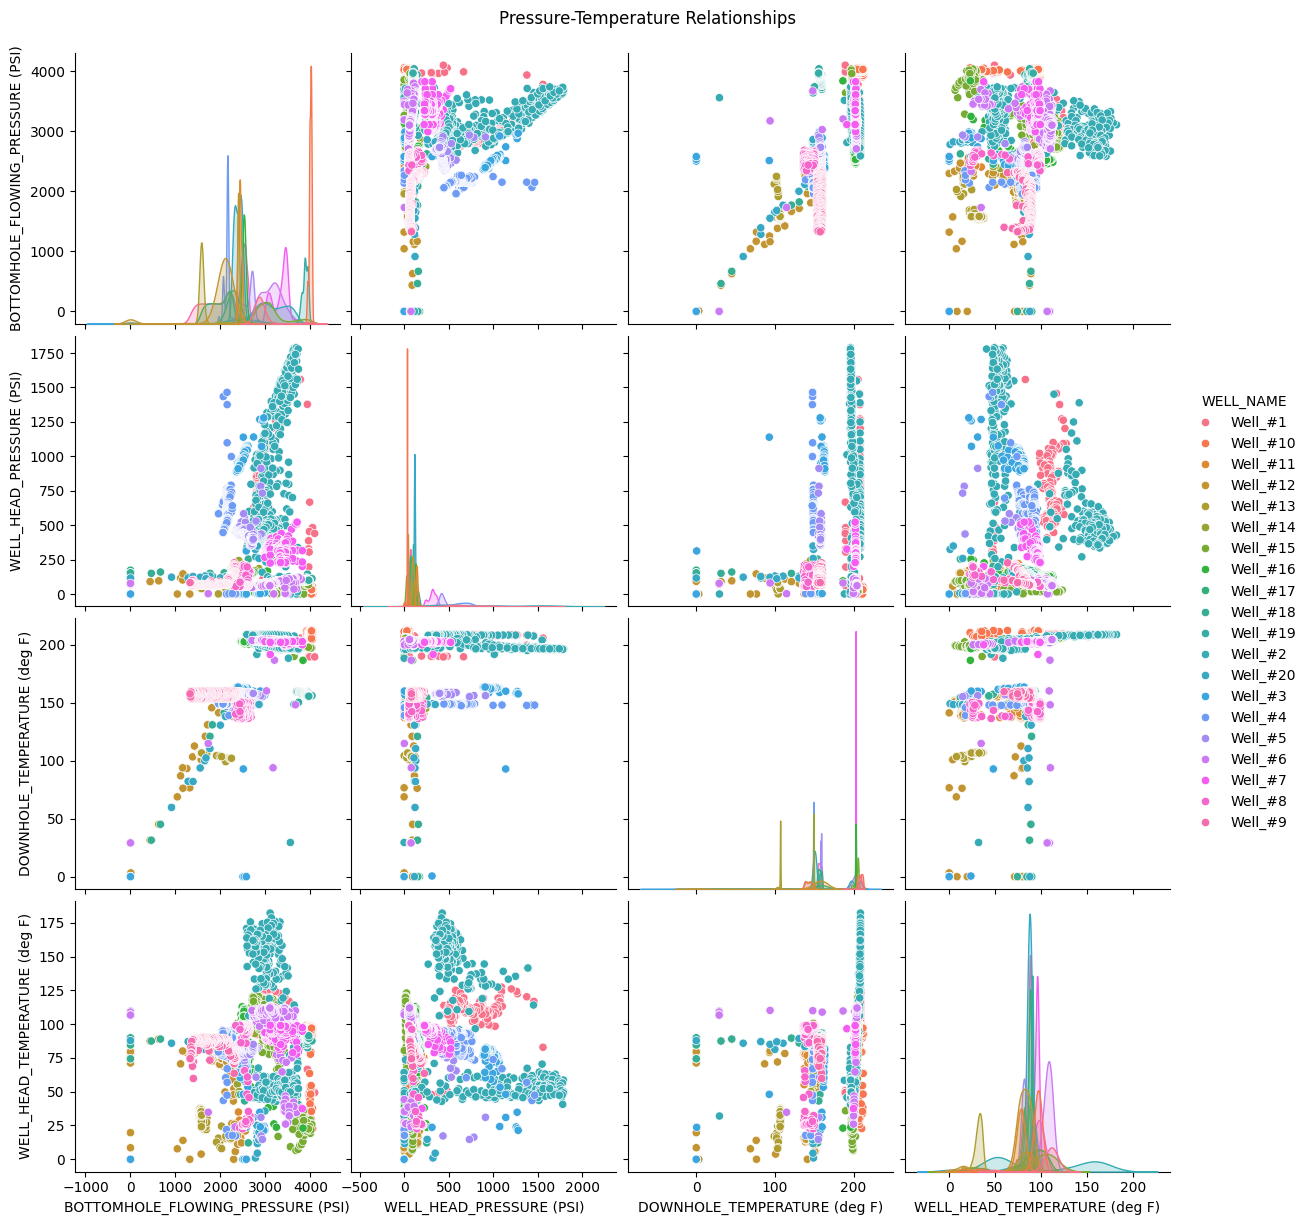

In [ ]:
# plotting the pressure temperature relationship

sns.pairplot(data=wells_df, vars=['BOTTOMHOLE_FLOWING_PRESSURE (PSI)',
                           'WELL_HEAD_PRESSURE (PSI)',
                           'DOWNHOLE_TEMPERATURE (deg F)',
                           'WELL_HEAD_TEMPERATURE (deg F)'],
             hue='WELL_NAME', height=3)
plt.suptitle('Pressure-Temperature Relationships', y=1.02)
plt.show()

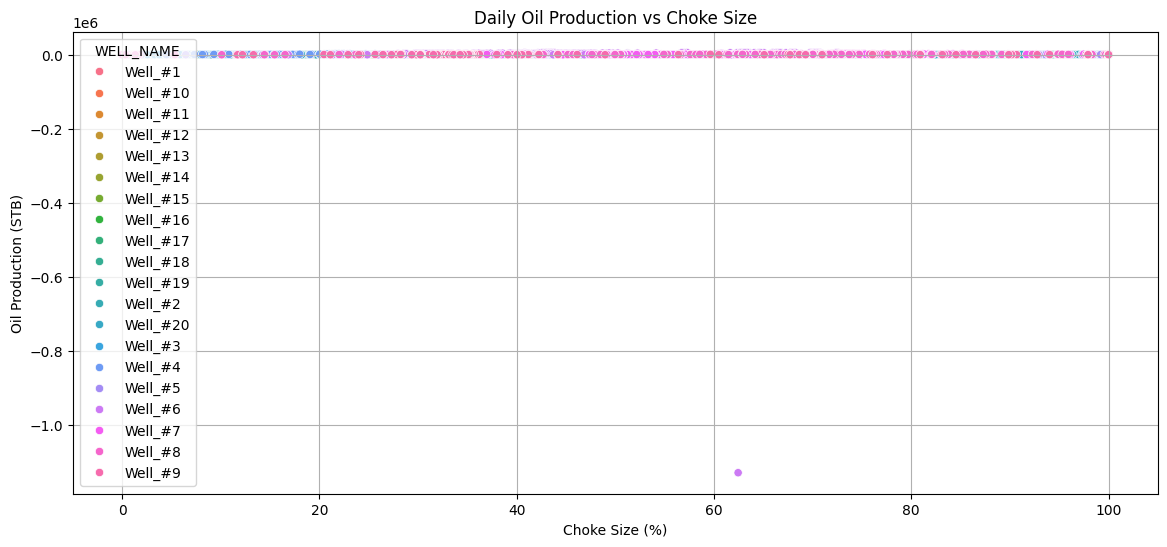

In [ ]:
# impact of choke size on production

plt.figure(figsize=(14, 6))
sns.scatterplot(data=wells_df, x='CHOKE_SIZE (%)', y='DAILY_OIL_PROD', hue='WELL_NAME')
plt.title('Daily Oil Production vs Choke Size')
plt.xlabel('Choke Size (%)')
plt.ylabel('Oil Production (STB)')
plt.grid(True)
plt.show()

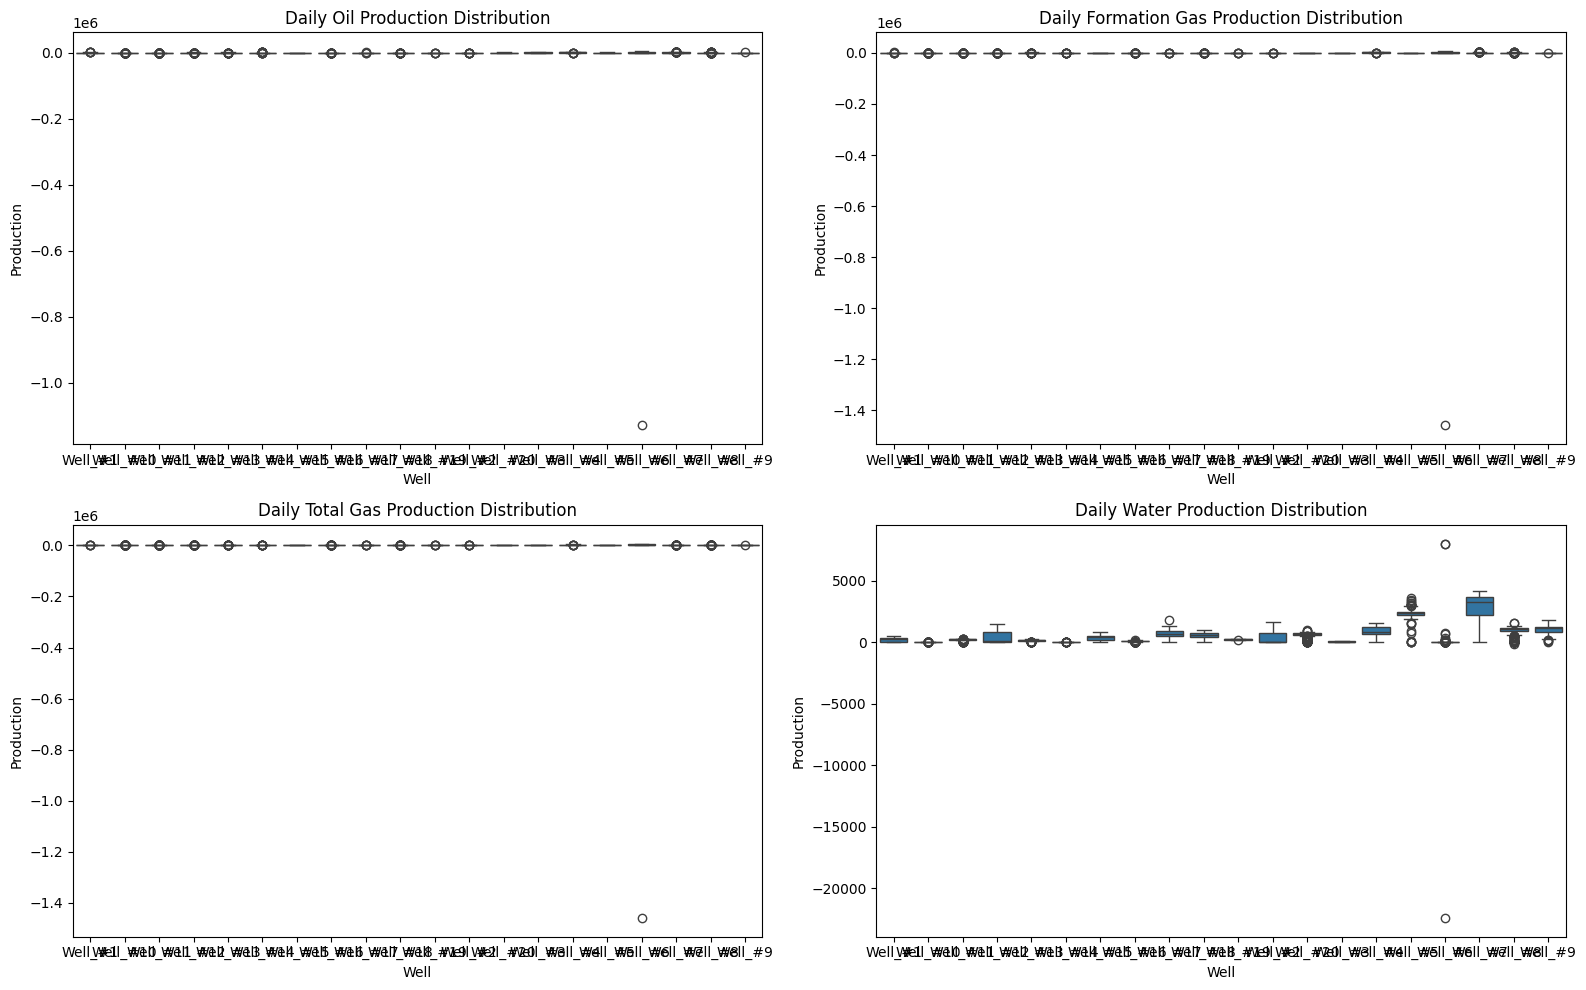

In [ ]:
# plotting the production distribution per well
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
for i, prod_type in enumerate(['OIL', 'FORMATION_GAS', 'TOTAL_GAS', 'WATER']):
    row, col = i//2, i%2
    sns.boxplot(data=wells_df, x='WELL_NAME', y=f'DAILY_{prod_type}_PROD', ax=axes[row,col])
    axes[row,col].set_title(f'Daily {prod_type.replace("_", " ").title()} Production Distribution')
    axes[row,col].set_xlabel('Well')
    axes[row,col].set_ylabel('Production')
plt.tight_layout()
plt.show()

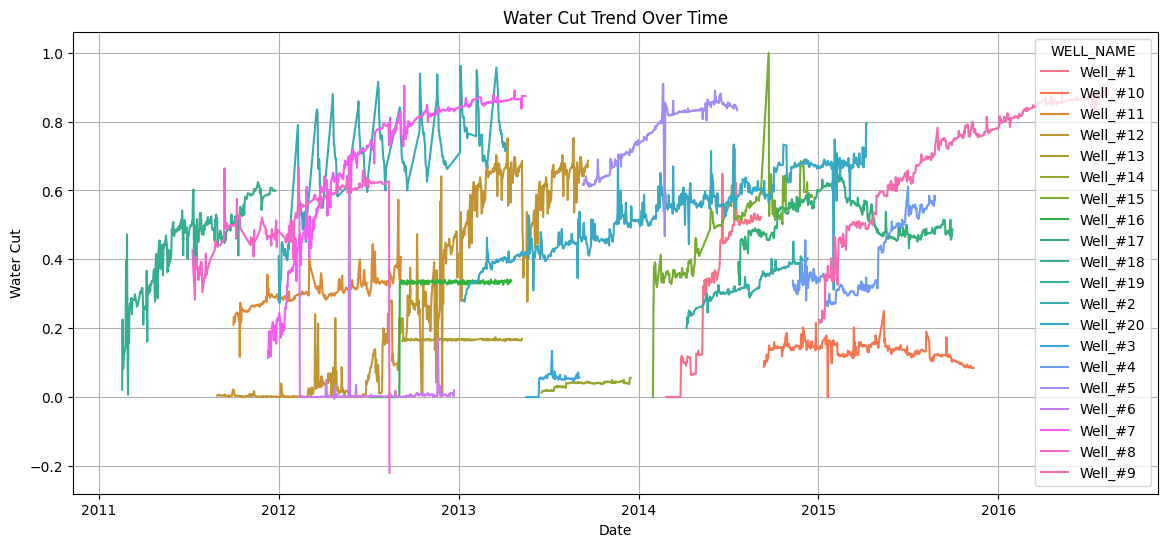

In [ ]:
# water cut analysis per well

plt.figure(figsize=(14, 6))
sns.lineplot(data=wells_df, x='PROD_DATE', y='WATER_CUT', hue='WELL_NAME')
plt.title('Water Cut Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Water Cut')
plt.grid(True)
plt.show()

/tmp/ipython-input-25-3843646949.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prod = wells_df.groupby(['WELL_NAME', pd.Grouper(key='PROD_DATE', freq='M')]).agg({


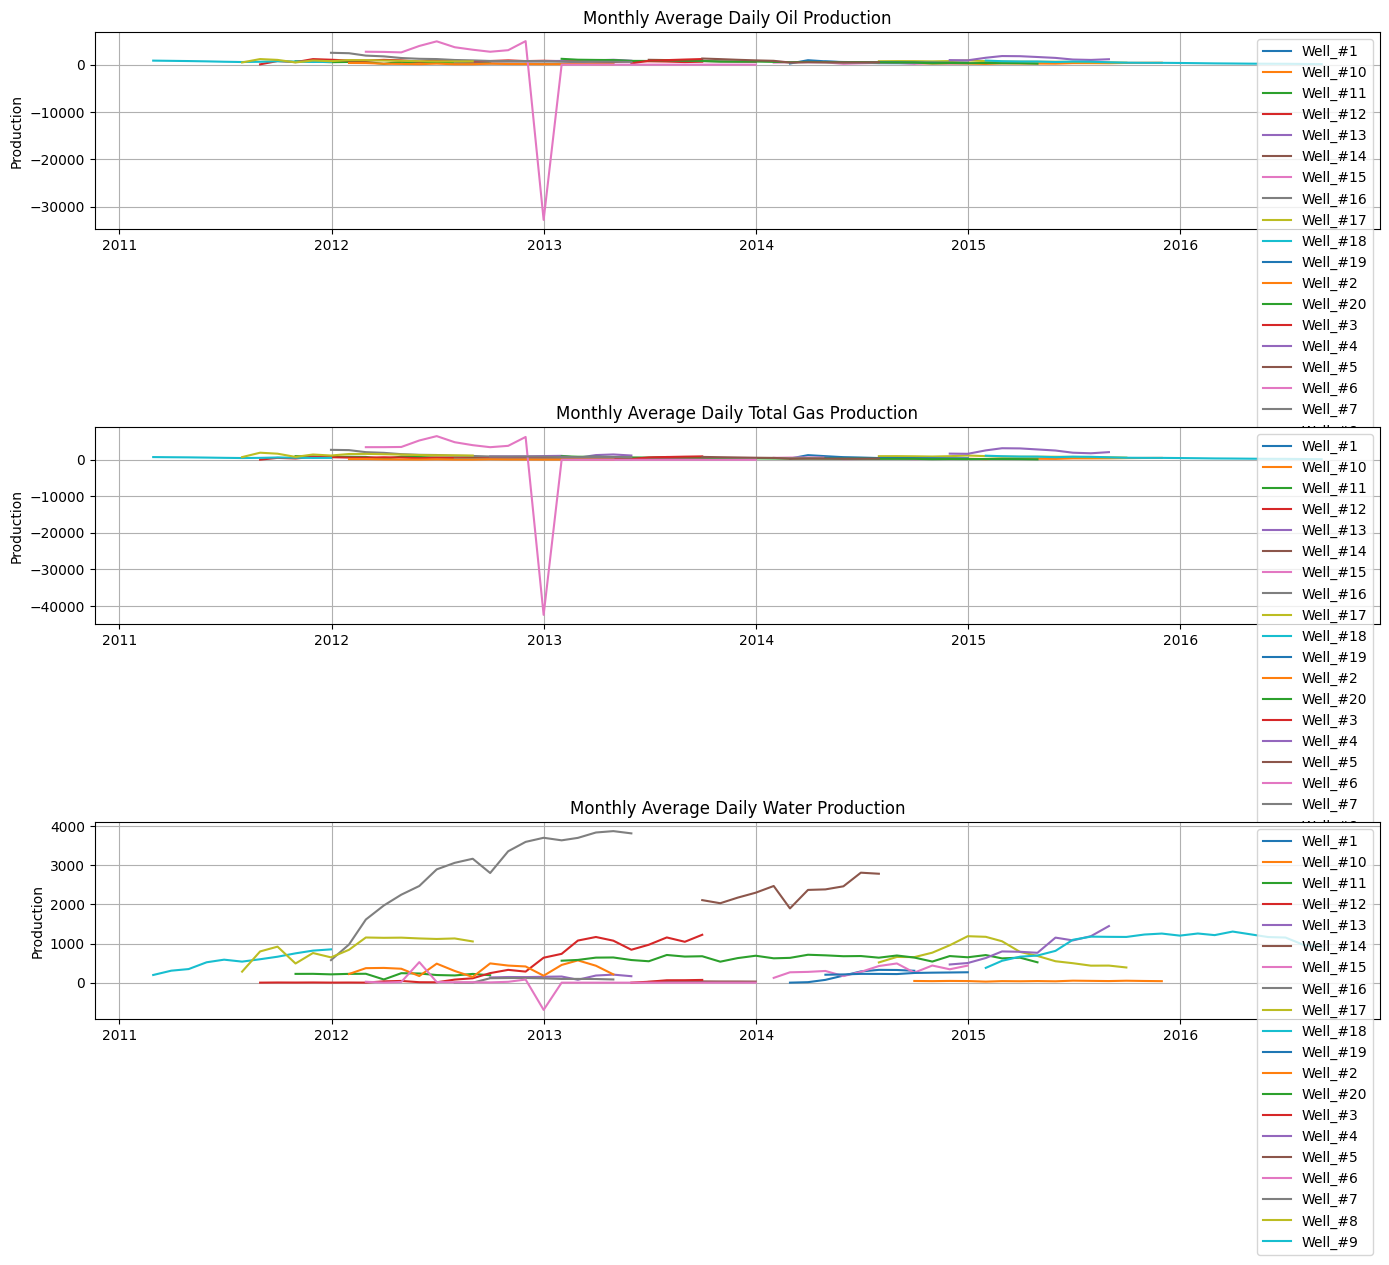

In [ ]:
# analysing the monthly production trend for each well

monthly_prod = wells_df.groupby(['WELL_NAME', pd.Grouper(key='PROD_DATE', freq='M')]).agg({
    'DAILY_OIL_PROD': 'mean',
    'DAILY_TOTAL_GAS_PROD': 'mean',
    'DAILY_WATER_PROD': 'mean'
}).reset_index()

fig, ax = plt.subplots(3, 1, figsize=(14, 12))
for i, prod_type in enumerate(['OIL', 'TOTAL_GAS', 'WATER']):
    for well in monthly_prod['WELL_NAME'].unique():
        well_data = monthly_prod[monthly_prod['WELL_NAME'] == well]
        ax[i].plot(well_data['PROD_DATE'], well_data[f'DAILY_{prod_type}_PROD'], label=well)
    ax[i].set_title(f'Monthly Average Daily {prod_type.replace("_", " ").title()} Production')
    ax[i].set_ylabel('Production')
    ax[i].legend()
    ax[i].grid(True)
plt.tight_layout()
plt.show()

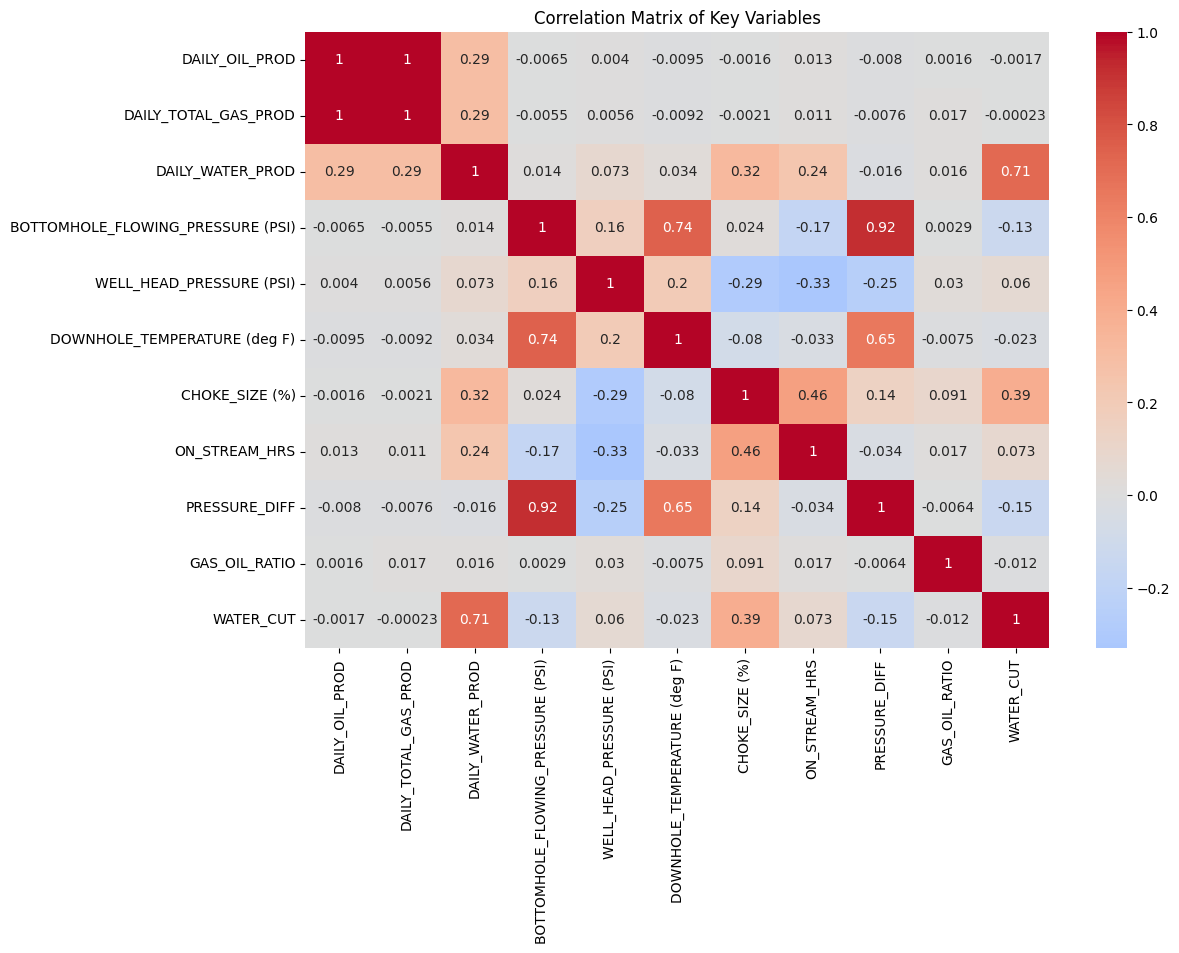

In [ ]:
# plotting the heatmap of key variables

corr_cols = ['DAILY_OIL_PROD', 'DAILY_TOTAL_GAS_PROD', 'DAILY_WATER_PROD',
             'BOTTOMHOLE_FLOWING_PRESSURE (PSI)', 'WELL_HEAD_PRESSURE (PSI)',
             'DOWNHOLE_TEMPERATURE (deg F)', 'CHOKE_SIZE (%)', 'ON_STREAM_HRS',
             'PRESSURE_DIFF', 'GAS_OIL_RATIO', 'WATER_CUT']

plt.figure(figsize=(12, 8))
sns.heatmap(wells_df[corr_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Key Variables')
plt.show()

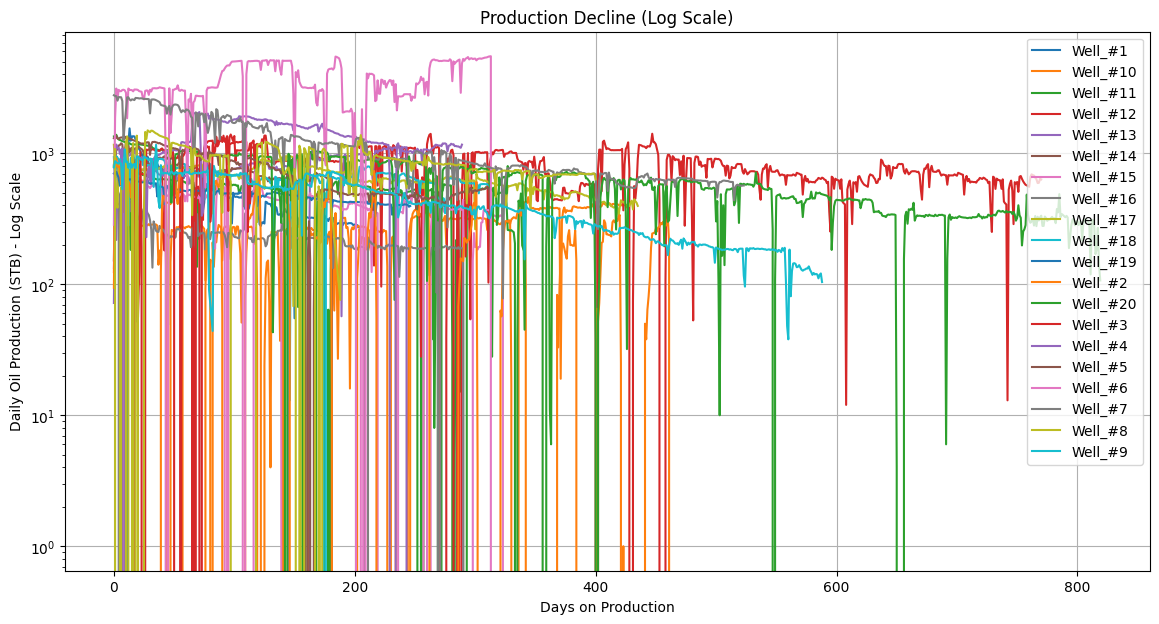

In [ ]:
# plotting how the production decline in each well

plt.figure(figsize=(14, 7))
for well in wells_df['WELL_NAME'].unique():
    well_data = wells_df[wells_df['WELL_NAME'] == well].sort_values('PROD_DATE')
    # Calculate days since first production
    well_data['DAYS_ON_PRODUCTION'] = (well_data['PROD_DATE'] - well_data['PROD_DATE'].min()).dt.days
    plt.plot(well_data['DAYS_ON_PRODUCTION'], well_data['DAILY_OIL_PROD'], label=well)
plt.yscale('log')
plt.title('Production Decline (Log Scale)')
plt.xlabel('Days on Production')
plt.ylabel('Daily Oil Production (STB) - Log Scale')
plt.legend()
plt.grid(True)
plt.show()

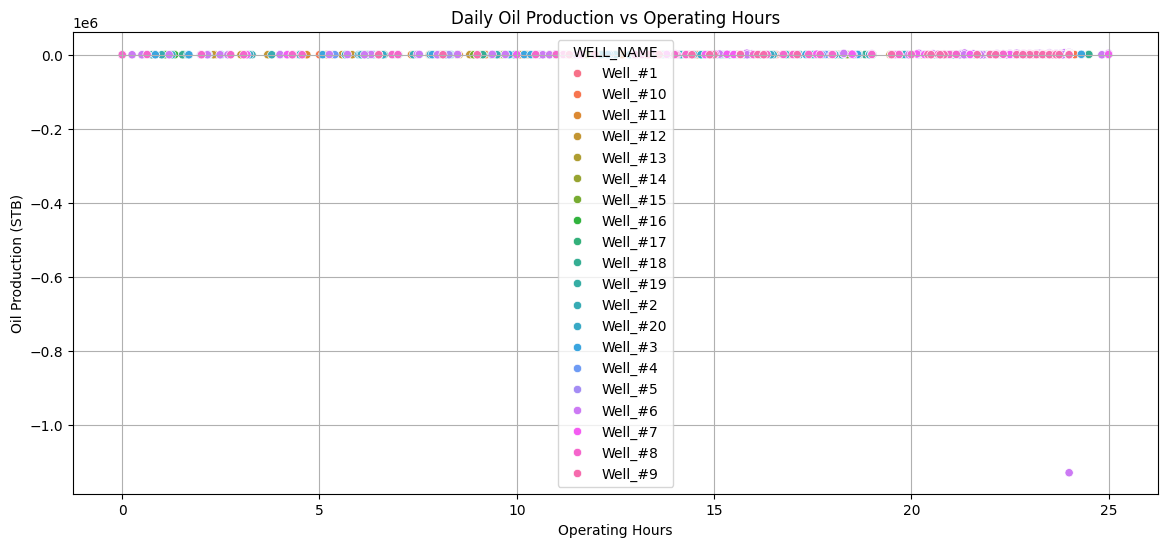

In [ ]:
# showing the operations and production per time
plt.figure(figsize=(14, 6))
sns.scatterplot(data=wells_df, x='ON_STREAM_HRS', y='DAILY_OIL_PROD', hue='WELL_NAME')
plt.title('Daily Oil Production vs Operating Hours')
plt.xlabel('Operating Hours')
plt.ylabel('Oil Production (STB)')
plt.grid(True)
plt.show()

## Working on the Reservoir Dataset

In [ ]:
# understanding the reservoir dataset
reservoir_df = reservoir_df.replace(',', '', regex=True).astype({
    'Initial Reservoir Pressure (PSI)': int,
    'Bubble Point Pressure (PSI)': int,
    'Current Average Reservoir Pressure (PSI)': int,
    'Solution Gas-Oil-Ratio (SCF/BBL)': int
})

In [ ]:
# Function to determine reservoir properties
def determine_reservoir_properties(df):
    # Determine reservoir type
    df['Reservoir Type'] = np.where(
        df['Current Average Reservoir Pressure (PSI)'] >= df['Bubble Point Pressure (PSI)'],
        'Undersat',  # Undersaturated
        'Saturated'  # Saturated
    )

    # Determine well type (this would normally come from production data, so we'll leave blank)
    df['Well Type'] = ''

    # Determine production type (this would require time series analysis, so we'll leave blank)
    df['Production Type'] = ''

    # Determine Formation GOR Trend
    df['Formation GOR Trend'] = np.where(
        df['Reservoir Type'] == 'Saturated',
        'aSolGOR',  # Above Solution GOR (since reservoir is below bubble point)
        'bSolGOR'   # At or below solution GOR (undersaturated reservoir)
    )

    # Watercut Trend and Oil PI Trend would require production data analysis
    # We'll initialize them as empty
    df['Watercut Trend'] = ''
    df['Oil Productivity Index Trend'] = ''

    return df


In [ ]:

# Apply the function to determine properties
reservoir_properties = determine_reservoir_properties(reservoir_df.copy())


In [ ]:
# Display the results
print("Reservoir Properties Classification:")
print(reservoir_properties[['Reservoir Name', 'Reservoir Type', 'Well Type', 'Production Type',
                          'Formation GOR Trend', 'Watercut Trend', 'Oil Productivity Index Trend']])

Reservoir Properties Classification:
  Reservoir Name Reservoir Type Well Type Production Type Formation GOR Trend  \
0           ACHI      Saturated                                       aSolGOR   
1           KEMA      Saturated                                       aSolGOR   
2           MAKO      Saturated                                       aSolGOR   
3           DEPU      Saturated                                       aSolGOR   
4           JANI      Saturated                                       aSolGOR   

  Watercut Trend Oil Productivity Index Trend  
0                                              
1                                              
2                                              
3                                              
4                                              


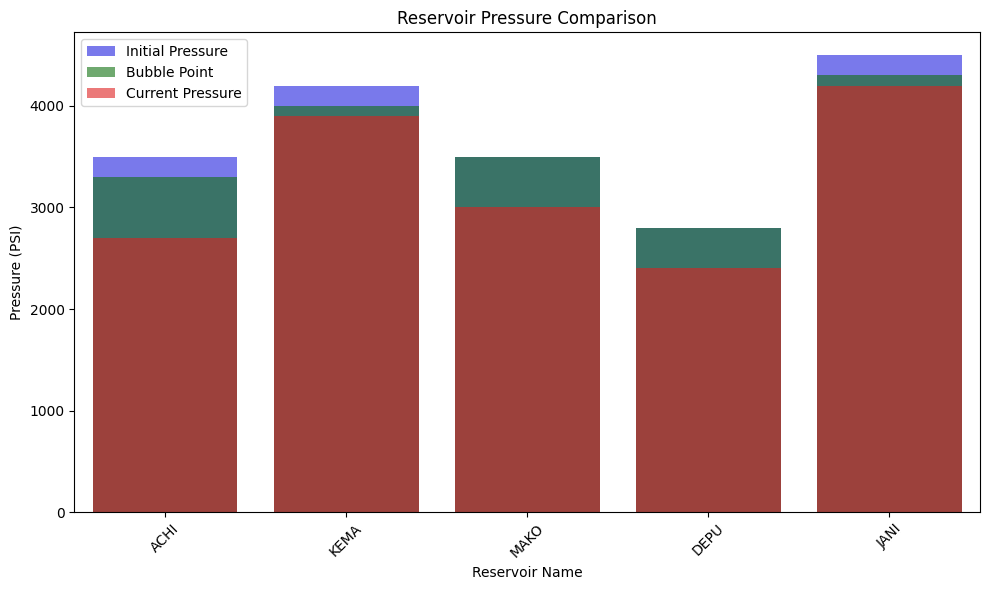

In [ ]:
# Visualization of reservoir pressures
plt.figure(figsize=(10, 6))
sns.barplot(x='Reservoir Name', y='Initial Reservoir Pressure (PSI)', data=reservoir_df,
            color='blue', alpha=0.6, label='Initial Pressure')
sns.barplot(x='Reservoir Name', y='Bubble Point Pressure (PSI)', data=reservoir_df,
            color='green', alpha=0.6, label='Bubble Point')
sns.barplot(x='Reservoir Name', y='Current Average Reservoir Pressure (PSI)', data=reservoir_df,
            color='red', alpha=0.6, label='Current Pressure')
plt.title('Reservoir Pressure Comparison')
plt.ylabel('Pressure (PSI)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Identify the reservoir each well is producing from

Identify the reservoir each well is producing from assuming not more than 200 psi differential pressure at the maximum bottom hole pressure.

In [ ]:
# Function to identify reservoirs for each well
def identify_reservoirs(reservoir_df, well_df):
    # Calculate max BHFP for each well
    max_bhfp = well_df.groupby('WELL_NAME')['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].max().reset_index()
    max_bhfp.columns = ['WELL_NAME', 'MAX_BHFP']

    # Initialize results dataframe
    results = []

    # For each well, find matching reservoirs within ±200 psi
    for _, well_row in max_bhfp.iterrows():
        well_name = well_row['WELL_NAME']
        well_pressure = well_row['MAX_BHFP']

        # Find reservoirs where current pressure is within ±200 psi of well's max BHFP
        matching_reservoirs = reservoir_df[
            abs(reservoir_df['Current Average Reservoir Pressure (PSI)'] - well_pressure) <= 200
        ]

        if len(matching_reservoirs) == 1:
            # Single match found
            reservoir = matching_reservoirs.iloc[0]['Reservoir Name']
            confidence = 'High'
        elif len(matching_reservoirs) > 1:
            # Multiple matches - choose closest
            matching_reservoirs['Pressure Diff'] = abs(
                matching_reservoirs['Current Average Reservoir Pressure (PSI)'] - well_pressure
            )
            reservoir = matching_reservoirs.nsmallest(1, 'Pressure Diff').iloc[0]['Reservoir Name']
            confidence = 'Medium'
        else:
            # No matches within 200 psi - find closest
            reservoir_df['Pressure Diff'] = abs(
                reservoir_df['Current Average Reservoir Pressure (PSI)'] - well_pressure
            )
            reservoir = reservoir_df.nsmallest(1, 'Pressure Diff').iloc[0]['Reservoir Name']
            confidence = 'Low'

        results.append({
            'WELL_NAME': well_name,
            'MAX_BHFP': well_pressure,
            'RESERVOIR': reservoir,
            'CONFIDENCE': confidence,
            'RESERVOIR_PRESSURE': reservoir_df[
                reservoir_df['Reservoir Name'] == reservoir
            ].iloc[0]['Current Average Reservoir Pressure (PSI)']
        })

    return pd.DataFrame(results)

/tmp/ipython-input-34-2651228016.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matching_reservoirs['Pressure Diff'] = abs(
/tmp/ipython-input-34-2651228016.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matching_reservoirs['Pressure Diff'] = abs(
/tmp/ipython-input-34-2651228016.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

Well to Reservoir Mapping:
   WELL_NAME RESERVOIR  MAX_BHFP  RESERVOIR_PRESSURE CONFIDENCE
0    Well_#1      JANI    4096.0                4200     Medium
1   Well_#10      JANI    4051.0                4200     Medium
2   Well_#11      DEPU    2521.0                2400     Medium
3   Well_#12      ACHI    2557.0                2700     Medium
4   Well_#13      DEPU    2246.0                2400       High
5   Well_#14      MAKO    2857.0                3000     Medium
6   Well_#15      KEMA    4032.0                3900     Medium
7   Well_#16      KEMA    3836.0                3900       High
8   Well_#17      DEPU    2304.0                2400       High
9   Well_#18      ACHI    2621.0                2700       High
10  Well_#19      KEMA    4036.0                3900     Medium
11   Well_#2      KEMA    3735.0                3900       High
12  Well_#20      MAKO    2858.0                3000     Medium
13   Well_#3      MAKO    2985.0                3000       High
14   Well_#4 

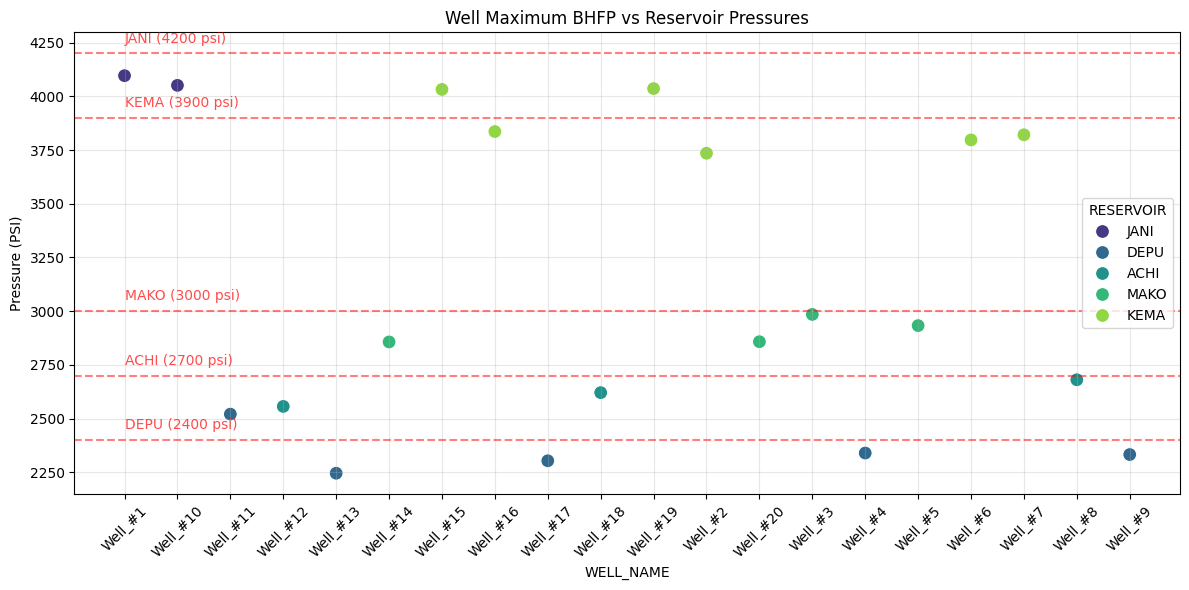


Results saved to 'well_reservoir_mapping.csv'


In [ ]:
# Main analysis
def main():
    # Load data
    # reservoir_df, well_df = load_and_clean_data() # Removed this line

    # Identify reservoirs for each well
    well_reservoir_mapping = identify_reservoirs(reservoir_df, wells_df) # Changed well_df to wells_df

    # Print results
    print("Well to Reservoir Mapping:")
    print(well_reservoir_mapping[['WELL_NAME', 'RESERVOIR', 'MAX_BHFP',
                                 'RESERVOIR_PRESSURE', 'CONFIDENCE']])

    # Visualization
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='WELL_NAME', y='MAX_BHFP', data=well_reservoir_mapping,
                    hue='RESERVOIR', s=100, palette='viridis')

    # Add reservoir pressure references
    for _, row in reservoir_df.iterrows():
        plt.axhline(y=row['Current Average Reservoir Pressure (PSI)'],
                    color='red', linestyle='--', alpha=0.5)
        plt.text(0, row['Current Average Reservoir Pressure (PSI)'] + 50,
                 f"{row['Reservoir Name']} ({row['Current Average Reservoir Pressure (PSI)']} psi)",
                 color='red', alpha=0.7)

    plt.title('Well Maximum BHFP vs Reservoir Pressures')
    plt.ylabel('Pressure (PSI)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Save results
    well_reservoir_mapping.to_csv('well_reservoir_mapping.csv', index=False)
    print("\nResults saved to 'well_reservoir_mapping.csv'")

if __name__ == '__main__':
    main()

## Saturation or Unsaturation of each Resorvoir

Determine for each reservoir whether saturated or undersaturated using the initial condition

In [ ]:
# Determine reservoir saturation status
def determine_saturation_status(row):
    if row['Initial Reservoir Pressure (PSI)'] > row['Bubble Point Pressure (PSI)']:
        return 'Undersaturated'
    elif row['Initial Reservoir Pressure (PSI)'] == row['Bubble Point Pressure (PSI)']:
        return 'Saturated (at bubble point)'
    else:
        return 'Saturated (below bubble point)'

In [ ]:
# Apply the function to determine saturation status
reservoir_df['Saturation Status'] = reservoir_df.apply(determine_saturation_status, axis=1)


In [ ]:
# Display the results
print("Reservoir Saturation Status:")
print(reservoir_df[['Reservoir Name', 'Initial Reservoir Pressure (PSI)',
                     'Bubble Point Pressure (PSI)', 'Saturation Status']])


Reservoir Saturation Status:
  Reservoir Name  Initial Reservoir Pressure (PSI)  \
0           ACHI                              3500   
1           KEMA                              4200   
2           MAKO                              3500   
3           DEPU                              2800   
4           JANI                              4500   

   Bubble Point Pressure (PSI)            Saturation Status  
0                         3300               Undersaturated  
1                         4000               Undersaturated  
2                         3500  Saturated (at bubble point)  
3                         2800  Saturated (at bubble point)  
4                         4300               Undersaturated  


## Gas Lifted or Natural Flowing

Identify whether the well is naturally flowing or gas lifted

In [ ]:
# Function to determine well type
def determine_well_type(group):
    # Criteria for gas lifted wells:
    # 1. Annulus pressure > 0 (gas injection present)
    # 2. Fluctuating annulus pressure (indicates active gas lift)
    if (group['ANNULUS_PRESS (PSI)'].max() > 100 and
        group['ANNULUS_PRESS (PSI)'].std() > 50):
        return 'Gas Lifted (GL)'
    else:
        return 'Naturally Flowing (NF)'

In [ ]:
# Group by well and apply determination
well_types = wells_df.groupby('WELL_NAME').apply(determine_well_type).reset_index()
well_types.columns = ['WELL_NAME', 'WELL_TYPE']

/tmp/ipython-input-40-492287758.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  well_types = wells_df.groupby('WELL_NAME').apply(determine_well_type).reset_index()


Well Classification Results:
   WELL_NAME RESERVOIR               WELL_TYPE
0    Well_#1      JANI         Gas Lifted (GL)
1   Well_#10      JANI         Gas Lifted (GL)
2   Well_#11      DEPU         Gas Lifted (GL)
3   Well_#12      ACHI  Naturally Flowing (NF)
4   Well_#13      DEPU  Naturally Flowing (NF)
5   Well_#14      MAKO  Naturally Flowing (NF)
6   Well_#15      KEMA  Naturally Flowing (NF)
7   Well_#16      KEMA  Naturally Flowing (NF)
8   Well_#17      DEPU         Gas Lifted (GL)
9   Well_#18      ACHI  Naturally Flowing (NF)
10  Well_#19      KEMA  Naturally Flowing (NF)
11   Well_#2      KEMA  Naturally Flowing (NF)
12  Well_#20      MAKO         Gas Lifted (GL)
13   Well_#3      MAKO         Gas Lifted (GL)
14   Well_#4      DEPU         Gas Lifted (GL)
15   Well_#5      MAKO  Naturally Flowing (NF)
16   Well_#6      KEMA  Naturally Flowing (NF)
17   Well_#7      KEMA         Gas Lifted (GL)
18   Well_#8      ACHI         Gas Lifted (GL)
19   Well_#9      DEPU         

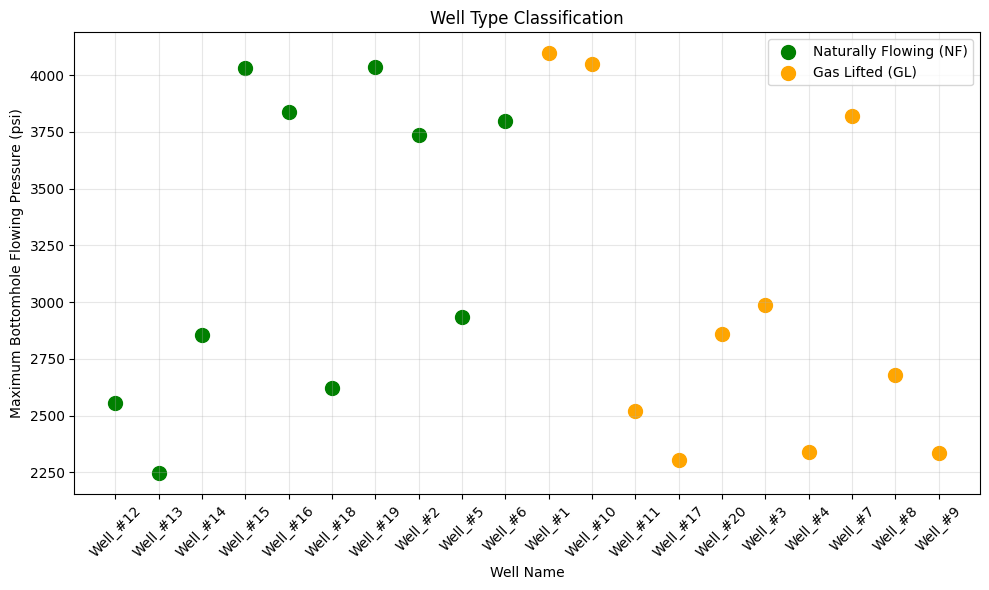

In [ ]:

# Merge with reservoir mapping (from previous analysis)
reservoir_mapping = pd.read_csv('well_reservoir_mapping.csv')
well_classification = pd.merge(reservoir_mapping, well_types, on='WELL_NAME')

# Display results
print("Well Classification Results:")
print(well_classification[['WELL_NAME', 'RESERVOIR', 'WELL_TYPE']])

# Visualization
plt.figure(figsize=(10, 6))
colors = {'Naturally Flowing (NF)': 'green', 'Gas Lifted (GL)': 'orange'}
for well_type, color in colors.items():
    subset = well_classification[well_classification['WELL_TYPE'] == well_type]
    plt.scatter(subset['WELL_NAME'], subset['MAX_BHFP'], color=color, label=well_type, s=100)

plt.title('Well Type Classification')
plt.ylabel('Maximum Bottomhole Flowing Pressure (psi)')
plt.xlabel('Well Name')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Steady or Unsteady Production

Determine if production from a well is steady or unsteady. Consider unsteady wells as those with more than 50% drop in oil production at least once every 3 to 6 months

In [ ]:
# Function to calculate daily oil production
def calculate_daily_production(df):
    df = df.sort_values('PROD_DATE')
    df['DAILY_OIL_PROD'] = df['CUMULATIVE_OIL_PROD (STB)'].diff()
    df['DAILY_OIL_PROD'] = df['DAILY_OIL_PROD'].fillna(0)
    df['PROD_CHANGE_PCT'] = df['DAILY_OIL_PROD'].pct_change() * 100
    return df

In [ ]:

# Function to determine production type
def determine_production_type(df):
    df = calculate_daily_production(df)

    # Check for 50% drops within 3-6 month windows
    df = df.set_index('PROD_DATE')
    unsteady_periods = 0

    # Analyze 6-month rolling windows
    for window in df['DAILY_OIL_PROD'].rolling('180D'):
        if len(window) > 1:  # Need at least 2 points to calculate drop
            max_prod = window.max()
            min_prod = window.min()
            if max_prod > 0 and (min_prod / max_prod) < 0.5:  # >50% drop
                unsteady_periods += 1
                if unsteady_periods >= 1:  # At least one occurrence in 6 months
                    return 'Unsteady'

    return 'Steady'

In [ ]:
# Apply to each well
production_types = wells_df.groupby('WELL_NAME').apply(determine_production_type, include_groups=False).reset_index()
production_types.columns = ['WELL_NAME', 'PRODUCTION_TYPE']

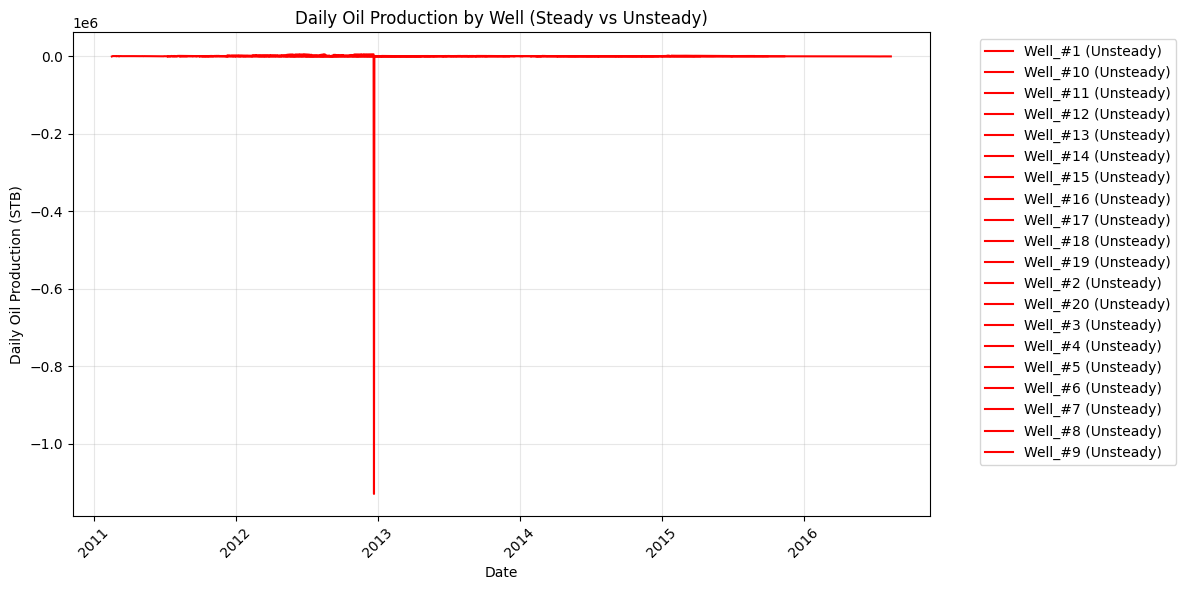

In [ ]:
# Visualization
plt.figure(figsize=(12, 6))
for well in final_classification['WELL_NAME'].unique():
    well_df = wells_df[wells_df['WELL_NAME'] == well].sort_values('PROD_DATE').copy()
    well_df = calculate_daily_production(well_df)
    prod_type = final_classification[final_classification['WELL_NAME'] == well]['PRODUCTION_TYPE'].values[0]
    color = 'red' if prod_type == 'Unsteady' else 'green'
    plt.plot(well_df['PROD_DATE'], well_df['DAILY_OIL_PROD'],
             label=f'{well} ({prod_type})', color=color)

plt.title('Daily Oil Production by Well (Steady vs Unsteady)')
plt.ylabel('Daily Oil Production (STB)')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## GOR TREND

Determine from the formation GOR trend whether the well is flowing at/below or above the solution GOR of the selected reservoir or a combination of both trends

In [ ]:
# Calculate daily rates and GOR
def calculate_gor_trends(df):
    df = df.sort_values('PROD_DATE')
    df['DAILY_OIL'] = df['CUMULATIVE_OIL_PROD (STB)'].diff()
    df['DAILY_GAS'] = df['CUMULATIVE_FORMATION_GAS_PROD (MSCF)'].diff()
    df['GOR'] = (df['DAILY_GAS'] * 1000) / df['DAILY_OIL']  # Convert MSCF to SCF
    return df

In [ ]:
# Classify GOR trend
def classify_gor_trend(gor_series, solution_gor):
    if len(gor_series) < 2:
        return 'Insufficient Data'

    # Calculate trend statistics
    slope, _, _, _, _ = linregress(np.arange(len(gor_series)), gor_series)
    above_solution = (gor_series > solution_gor).mean()

    # Classification logic
    if above_solution > 0.8:  # Mostly above solution GOR
        return 'aSolGOR'
    elif above_solution < 0.2:  # Mostly below solution GOR
        return 'bSolGOR'
    elif abs(slope) > 0.5:  # Significant trend
        if slope > 0 and above_solution > 0.3:
            return 'Combo (Increasing to aSolGOR)'
        elif slope < 0 and above_solution < 0.7:
            return 'Combo (Decreasing to bSolGOR)'
        else:
            return 'Combo'
    else:
        return 'Combo'

In [ ]:
from scipy.stats import linregress
import pandas as pd # Import pandas if not already imported

# Load the final_classification dataframe
# final_classification = pd.read_csv('well_classification_with_type.csv') # Removed this line

# Process each well
gor_results = []
for _, well_row in final_classification.iterrows():
    well_name = well_row['WELL_NAME']
    reservoir = well_row['RESERVOIR']
    solution_gor = reservoir_df[reservoir_df['Reservoir Name'] == reservoir]['Solution Gas-Oil-Ratio (SCF/BBL)'].values[0]

    well_df = wells_df[wells_df['WELL_NAME'] == well_name].copy()
    well_df = calculate_gor_trends(well_df)

    # Remove zeros and outliers
    well_df = well_df[(well_df['GOR'] > 0) & (well_df['GOR'] < solution_gor * 3)]

    if len(well_df) > 1:
        # Calculate linear regression slope for trend analysis
        slope, _, _, _, _ = linregress(np.arange(len(well_df)), well_df['GOR'])

        # Classify GOR trend based on slope and comparison to solution_gor
        if well_df['GOR'].mean() > solution_gor and slope > 0:
            gor_trend = 'aSolGOR (Increasing)'
        elif well_df['GOR'].mean() < solution_gor and slope < 0:
            gor_trend = 'bSolGOR (Decreasing)'
        elif well_df['GOR'].mean() > solution_gor:
            gor_trend = 'aSolGOR'
        elif well_df['GOR'].mean() < solution_gor:
            gor_trend = 'bSolGOR'
        else:
            gor_trend = 'Combo'
    else:
        gor_trend = 'Insufficient Data'

    gor_results.append({
        'WELL_NAME': well_name,
        'RESERVOIR': reservoir,
        'SOLUTION_GOR': solution_gor,
        'AVG_PRODUCED_GOR': well_df['GOR'].mean() if len(well_df) > 0 else np.nan,
        'GOR_TREND': gor_trend
    })

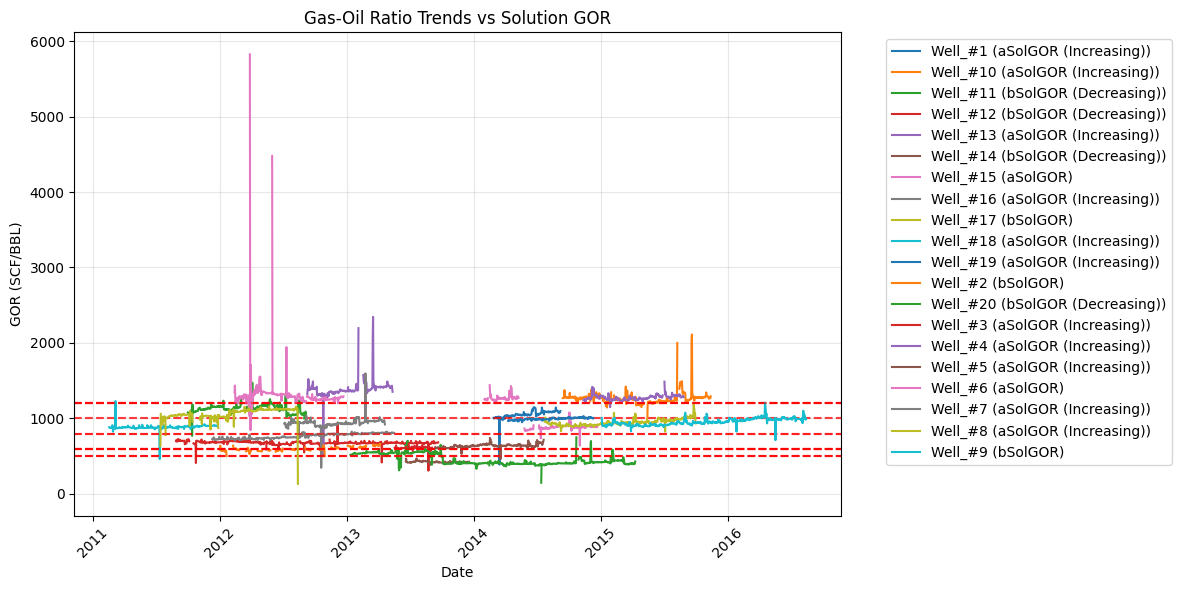

In [ ]:
# Merge with existing classification
final_classification = pd.merge(final_classification, pd.DataFrame(gor_results)[['WELL_NAME', 'GOR_TREND']], on='WELL_NAME')

# Display results
#print("GOR Trend Classification:")
#print(final_classification[['WELL_NAME', 'RESERVOIR', 'WELL_TYPE', 'PRODUCTION_TYPE', 'GOR_TREND']]) # Removed commented out print

# Visualization
plt.figure(figsize=(12, 6))
for _, row in pd.DataFrame(gor_results).iterrows(): # Use gor_results dataframe
    well_df = wells_df[wells_df['WELL_NAME'] == row['WELL_NAME']].copy() # Use wells_df
    well_df = calculate_gor_trends(well_df)

    plt.plot(well_df['PROD_DATE'], well_df['GOR'],
             label=f"{row['WELL_NAME']} ({row['GOR_TREND']})")
    plt.axhline(y=row['SOLUTION_GOR'], color='r', linestyle='--', alpha=0.5)

plt.title('Gas-Oil Ratio Trends vs Solution GOR')
plt.ylabel('GOR (SCF/BBL)')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Decision Tree Model**

In [ ]:
# Feature Engineering
def engineer_features(df, reservoir_df, well_reservoir_mapping):
    df = wells_df.sort_values(['WELL_NAME', 'PROD_DATE'])

    # Daily production rates
    df['DAILY_OIL'] = wells_df.groupby('WELL_NAME')['CUMULATIVE_OIL_PROD (STB)'].diff().fillna(0)
    df['DAILY_GAS'] = wells_df.groupby('WELL_NAME')['CUMULATIVE_FORMATION_GAS_PROD (MSCF)'].diff().fillna(0)
    df['DAILY_WATER'] = wells_df.groupby('WELL_NAME')['CUMULATIVE_WATER_PROD (BBL)'].diff().fillna(0)

    # Key metrics
    df['GOR'] = df['DAILY_GAS'] / df['DAILY_OIL'].replace(0, np.nan)
    df['WATERCUT'] = df['DAILY_WATER'] / (df['DAILY_OIL'] + df['DAILY_WATER']).replace(0, np.nan)

    # Calculate PI using reservoir pressure
    def calculate_pi(row):
        well_name = row['WELL_NAME']
        reservoir_info = well_reservoir_mapping[well_reservoir_mapping['WELL_NAME'] == well_name]
        if not reservoir_info.empty:
            reservoir_name = reservoir_info.iloc[0]['RESERVOIR']
            reservoir_pressure = reservoir_df[reservoir_df['Reservoir Name'] == reservoir_name]['Current Average Reservoir Pressure (PSI)'].values
            if len(reservoir_pressure) > 0:
                pressure_diff = reservoir_pressure[0] - row['BOTTOMHOLE_FLOWING_PRESSURE (PSI)']
                # Avoid division by zero or non-positive pressure difference
                if pressure_diff > 0:
                    return row['DAILY_OIL'] / pressure_diff
        return np.nan # Return NaN if calculation is not possible

    df['PI'] = df.apply(calculate_pi, axis=1)


    return df

well_data = engineer_features(wells_df.copy(), reservoir_df, reservoir_mapping)

In [ ]:
# Aggregate well-level features
def aggregate_well_features(df):
    features = []
    for well in df['WELL_NAME'].unique():
        well_df = df[df['WELL_NAME'] == well]

        # Trend features
        features.append({
            'WELL_NAME': well,
            'GOR_TREND': 'Increasing' if well_df['GOR'].pct_change().mean() > 0 else 'Decreasing',
            'WATERCUT_TREND': 'Increasing' if well_df['WATERCUT'].pct_change().mean() > 0 else 'Decreasing',
            'PI_TREND': 'Decreasing' if well_df['PI'].pct_change().mean() < 0 else 'Increasing',
            'PROD_STEADINESS': 'Unsteady' if (well_df['DAILY_OIL'].pct_change().abs() > 0.5).any() else 'Steady'
        })
    return pd.DataFrame(features)

well_features = aggregate_well_features(well_data)


/tmp/ipython-input-52-1660580424.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  'GOR_TREND': 'Increasing' if well_df['GOR'].pct_change().mean() > 0 else 'Decreasing',
/tmp/ipython-input-52-1660580424.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  'WATERCUT_TREND': 'Increasing' if well_df['WATERCUT'].pct_change().mean() > 0 else 'Decreasing',
/tmp/ipython-input-52-1660580424.py:12: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill

In [ ]:
# Merge well features with classification labels
# Assuming 'Reservoir Name' in classification_df corresponds to the reservoir identified for each well in well_features
# We need to first map the Reservoir Name from well_features to classification_df
well_features_with_reservoir = pd.merge(well_features, reservoir_mapping[['WELL_NAME', 'RESERVOIR']], on='WELL_NAME')
merged_data = pd.merge(well_features_with_reservoir, classification_df, left_on='RESERVOIR', right_on='Reservoir Name', how='left')

# Define features (X) and target (y) from the merged data
# Drop the original Reservoir Name column from classification_df and the redundant RESERVOIR column
X = merged_data.drop(['WELL_NAME', 'RESERVOIR', 'Reservoir Name', 'Reservoir Type', 'Well Type', 'Production Type', 'Formation GOR Trend', 'Watercut Trend', 'Oil Productivity Index Trend'], axis=1)
y = merged_data[['Reservoir Type', 'Well Type', 'Production Type', 'Formation GOR Trend', 'Watercut Trend', 'Oil Productivity Index Trend']]

In [ ]:
# Preprocess categorical features
# Identify categorical columns in X
categorical_cols = X.select_dtypes(include='object').columns

# Fill NaN values in categorical columns with a placeholder (e.g., 'Unknown')
X[categorical_cols] = X[categorical_cols].fillna('Unknown')

# Perform one-hot encoding
X = pd.get_dummies(X)

# Identify numerical columns in X (after one-hot encoding)
numerical_cols = X.select_dtypes(include=np.number).columns

# Impute missing values in numerical columns (e.g., with the median)
for col in numerical_cols:
    if X[col].isnull().any():
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)

In [ ]:
# Drop rows where the target variable ('Reservoir Type') is NaN before splitting
cleaned_y = y['Reservoir Type'].dropna()
cleaned_X = X.loc[cleaned_y.index]

# Split data
X_train, X_test, y_train, y_test = train_test_split(cleaned_X, cleaned_y, test_size=0.2, random_state=42)

In [ ]:
# Check for missing values in your features (X) and target (y)
print(X_train.isnull().sum())
print(y_train.isnull().sum())

# Handle missing values (either remove or impute)
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Keep corresponding y values
y_train = y_train.dropna() # Drop NaN values from y_train

GOR_TREND_Decreasing         0
GOR_TREND_Increasing         0
WATERCUT_TREND_Increasing    0
PI_TREND_Increasing          0
PROD_STEADINESS_Unsteady     0
dtype: int64
0


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (7, 5)
y_train shape: (7,)


In [ ]:
# Initialize and train
dt = DecisionTreeClassifier(
    max_depth=5,
    criterion='gini',
    min_samples_split=10
)

dt.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, min_samples_split=10)

In [ ]:

# Evaluate
print("Decision Tree Performance:")
print(classification_report(y_test, dt.predict(X_test)))


# Feature Importance
pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt.feature_importances_
}).sort_values('Importance', ascending=False)

Decision Tree Performance:
              precision    recall  f1-score   support

    Undersat       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



,Feature,Importance
0,GOR_TREND_Decreasing,0.0
1,GOR_TREND_Increasing,0.0
2,WATERCUT_TREND_Increasing,0.0
3,PI_TREND_Increasing,0.0
4,PROD_STEADINESS_Unsteady,0.0


In [ ]:
# Define features (X) and target (y)
# Use the final_classification DataFrame that includes the 'PRODUCTION_TYPE' column
X = final_classification[['WELL_TYPE']] # Add other relevant features as needed
y = final_classification[['RESERVOIR']]

In [ ]:

# Evaluate the model
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_predictions))

NameError: name 'dt_model' is not defined

## **LightGBM**

In [ ]:
# Train LightGBM
lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective='binary' # Changed objective to 'binary'
    # Removed num_class as it's not needed for binary classification
)
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 4, number of negative: 3
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 7, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.571429 -> initscore=0.287682
[LightGBM] [Info] Start training from score 0.287682
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there 

LGBMClassifier(max_depth=3, objective='binary')

In [ ]:
# Evaluate
print("LightGBM Performance:")
print(classification_report(y_test, lgbm.predict(X_test)))



LightGBM Performance:
              precision    recall  f1-score   support

    Undersat       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [ ]:
# Feature Importance (LightGBM)
pd.DataFrame({
    'Feature': X_train.columns, # Changed from X.columns to X_train.columns
    'Importance': lgbm.feature_importances_
}).sort_values('Importance', ascending=False)

,Feature,Importance
0,GOR_TREND_Decreasing,0
1,GOR_TREND_Increasing,0
2,WATERCUT_TREND_Increasing,0
3,PI_TREND_Increasing,0
4,PROD_STEADINESS_Unsteady,0


In [ ]:
# Predict reservoir categories for all wells
well_names = wells_df['WELL_NAME'].unique()
predictions = []


In [ ]:
for well in well_names:
    # Get the classification data for the current well
    well_classification_data = final_classification[final_classification['WELL_NAME'] == well]

    if not well_classification_data.empty:
        # Select the relevant features (matching X_train columns)
        well_features = well_classification_data[['WELL_TYPE', 'PRODUCTION_TYPE', 'GOR_TREND']]

        # Apply one-hot encoding to match the training data's feature format
        # Ensure that all possible categories from the training data are considered during encoding
        well_features_encoded = pd.get_dummies(well_features)

        # Align columns with X_train - add missing columns with 0 and reorder
        missing_cols = set(X_train.columns) - set(well_features_encoded.columns)
        for c in missing_cols:
            well_features_encoded[c] = 0
        well_features_encoded = well_features_encoded[X_train.columns]


        # Use the LGBM model for prediction
        # Make sure the model variable name is correct (lgbm in this case)
        pred = lgbm.predict(well_features_encoded)

        # The prediction is already a single value for the well since well_features_encoded has one row
        pred_label = pred[0]
        predictions.append((well, pred_label))
    else:
        predictions.append((well, 'Classification Data Not Available')) # Handle cases with no classification data

In [ ]:
# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['WELL_NAME', 'PREDICTED_RESERVOIR'])


In [ ]:

# Display the predictions
print("Predicted Reservoir Categories for Wells:")
print(predictions_df)


Predicted Reservoir Categories for Wells:
   WELL_NAME PREDICTED_RESERVOIR
0    Well_#1            Undersat
1   Well_#10            Undersat
2   Well_#11            Undersat
3   Well_#12            Undersat
4   Well_#13            Undersat
5   Well_#14            Undersat
6   Well_#15            Undersat
7   Well_#16            Undersat
8   Well_#17            Undersat
9   Well_#18            Undersat
10  Well_#19            Undersat
11   Well_#2            Undersat
12  Well_#20            Undersat
13   Well_#3            Undersat
14   Well_#4            Undersat
15   Well_#5            Undersat
16   Well_#6            Undersat
17   Well_#7            Undersat
18   Well_#8            Undersat
19   Well_#9            Undersat
